# Visual Data Exploration with R
### Boryana Manz

This report includes analysis of a life insurance dataset from Prudential, made available as a Kaggle competition <https://www.kaggle.com/c/prudential-life-insurance-assessment>. The objective of the dataset challenge is to automate classification of a life-insurance policy candidate into an appropriate category, given extensive personal and medical information. For the purposes of this challenge there are 8 "Response" ordinal levels that need to be predicted.  
The data is anonymized with variables presented as "Medical_History/Keyword_\#" etc. Numerical variables like BMI have been normalized and scaled to 0-1.

The goal of this visual analysis is to provide a better understanding of the variables that strongly influence Response. It also may suggest directions for feature engineering that would better reflect the underlying data and its relationships.

## Data Variables

In [36]:
library(dplyr)
library(ggplot2)
library(caret)
library(randomForest)
library(RColorBrewer)
library(repr)
library(scales)

In [4]:
# Loading data
# train<- read_csv("train.csv")
names(train)

[1] "Id"                  "Product_Info_1"      "Product_Info_2"     
  [4] "Product_Info_3"      "Product_Info_4"      "Product_Info_5"     
  [7] "Product_Info_6"      "Product_Info_7"      "Ins_Age"            
 [10] "Ht"                  "Wt"                  "BMI"                
 [13] "Employment_Info_1"   "Employment_Info_2"   "Employment_Info_3"  
 [16] "Employment_Info_4"   "Employment_Info_5"   "Employment_Info_6"  
 [19] "InsuredInfo_1"       "InsuredInfo_2"       "InsuredInfo_3"      
 [22] "InsuredInfo_4"       "InsuredInfo_5"       "InsuredInfo_6"      
 [25] "InsuredInfo_7"       "Insurance_History_1" "Insurance_History_2"
 [28] "Insurance_History_3" "Insurance_History_4" "Insurance_History_5"
 [31] "Insurance_History_7" "Insurance_History_8" "Insurance_History_9"
 [34] "Family_Hist_1"       "Family_Hist_2"       "Family_Hist_3"      
 [37] "Family_Hist_4"       "Family_Hist_5"       "Medical_History_1"  
 [40] "Medical_History_2"   "Medical_History_3"   "Medical_History_4"  
 [43] "Medical_History_5"   "Medical_History_6"   "Medical_History_7"  
 [46] "Medical_History_8"   "Medical_History_9"   "Medical_History_10" 
 [49] "Medical_History_11"  "Medical_History_12"  "Medical_History_13" 
 [52] "Medical_History_14"  "Medical_History_15"  "Medical_History_16" 
 [55] "Medical_History_17"  "Medical_History_18"  "Medical_History_19" 
 [58] "Medical_History_20"  "Medical_History_21"  "Medical_History_22" 
 [61] "Medical_History_23"  "Medical_History_24"  "Medical_History_25" 
 [64] "Medical_History_26"  "Medical_History_27"  "Medical_History_28" 
 [67] "Medical_History_29"  "Medical_History_30"  "Medical_History_31" 
 [70] "Medical_History_32"  "Medical_History_33"  "Medical_History_34" 
 [73] "Medical_History_35"  "Medical_History_36"  "Medical_History_37" 
 [76] "Medical_History_38"  "Medical_History_39"  "Medical_History_40" 
 [79] "Medical_History_41"  "Medical_Keyword_1"   "Medical_Keyword_2"  
 [82] "Medical_Keyword_3"   "Medical_Keyword_4"   "Medical_Keyword_5"  
 [85] "Medical_Keyword_6"   "Medical_Keyword_7"   "Medical_Keyword_8"  
 [88] "Medical_Keyword_9"   "Medical_Keyword_10"  "Medical_Keyword_11" 
 [91] "Medical_Keyword_12"  "Medical_Keyword_13"  "Medical_Keyword_14" 
 [94] "Medical_Keyword_15"  "Medical_Keyword_16"  "Medical_Keyword_17" 
 [97] "Medical_Keyword_18"  "Medical_Keyword_19"  "Medical_Keyword_20" 
[100] "Medical_Keyword_21"  "Medical_Keyword_22"  "Medical_Keyword_23" 
[103] "Medical_Keyword_24"  "Medical_Keyword_25"  "Medical_Keyword_26" 
[106] "Medical_Keyword_27"  "Medical_Keyword_28"  "Medical_Keyword_29" 
[109] "Medical_Keyword_30"  "Medical_Keyword_31"  "Medical_Keyword_32" 
[112] "Medical_Keyword_33"  "Medical_Keyword_34"  "Medical_Keyword_35" 
[115] "Medical_Keyword_36"  "Medical_Keyword_37"  "Medical_Keyword_38" 
[118] "Medical_Keyword_39"  "Medical_Keyword_40"  "Medical_Keyword_41" 
[121] "Medical_Keyword_42"  "Medical_Keyword_43"  "Medical_Keyword_44" 
[124] "Medical_Keyword_45"  "Medical_Keyword_46"  "Medical_Keyword_47" 
[127] "Medical_Keyword_48"  "Response"

## BMI and Age
BMI and Age are expected to be key parameters in evaluating life-insurance policies. There is a significant variation of BMI with Age. The pattern of BMI and Age differ with Response Type. Response 4 and 8 are lean at all ages, while 1,2,5,6 demonstrate higher BMI, peaking at midlife. Response 5 especially exhibit high BMI at in early life, suggesting they might be associated with some disease. In developing features for predictive analytics, it might be useful to generate new combinations of BMI with Age, or transform BMI to enhance the separation between Response groups. Additionaly, BMI can be independently calculated from the provided Weight and Height data.

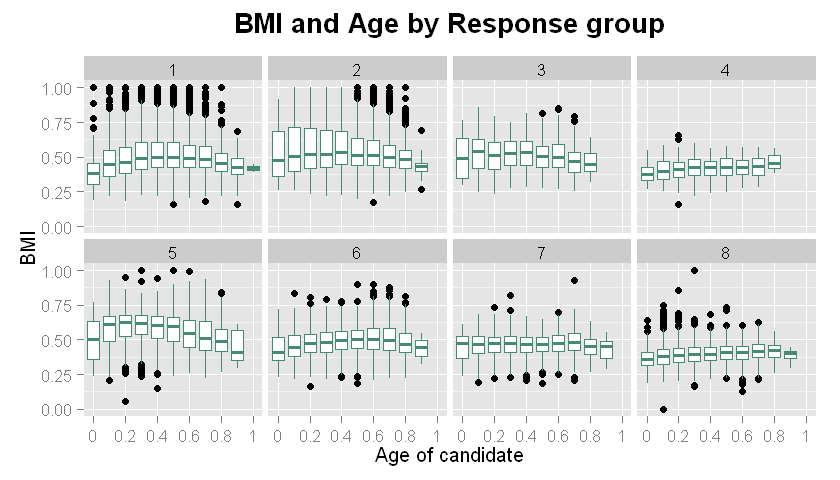

In [12]:
options(repr.plot.width=7, repr.plot.height=4)
BMIAge= train %>%
        select(BMI, Response, Ins_Age) %>%
        mutate(Ageb = round(Ins_Age,1))
d = ggplot(BMIAge, aes(factor(Ageb), BMI))
d = d + geom_boxplot(color = "aquamarine4")
d = d + facet_wrap(~ Response, nrow = 2)
d = d + xlab("Age of candidate")
d = d + ggtitle("BMI and Age by Response group") 
d = d + theme(plot.title = element_text(face = "bold", size = 16, vjust = 2))
d = d + scale_x_discrete(breaks = pretty(BMIAge$Ageb, n = 5))
d


## Associations with Response
Looping through all variables (sample plot below) reveals variables that are associated with Response. 

In [24]:
BMscan = function(train, target) {  
  # Histogram of target variable in train dataset, overlayed by Response 
  df= train %>% select(Response, which(names(train) == target))
  df = data.frame(df)
  df[[1]] = factor(df[[1]])
  names(df) = c("name1", "name2")
  d = ggplot(df, aes(x = name2, fill = name1)) + geom_density(alpha = 0.4) + scale_fill_manual(values=heat.colors(8))
  # print(d) 
  return(d)  
}
readkey = function() {
  print("Press any key to continue")
  line = readline()
}

Several variables are unevenly distributed among the Response levels: BMI,Ins_Age, Employment_Info_2, Medical_History_4,6,10,24, Medical_Keyword_15,25. As an example, Medical_History_10 stands out as skewed to low or high Response.

Warning message:
: Removed 58824 rows containing non-finite values (stat_density).

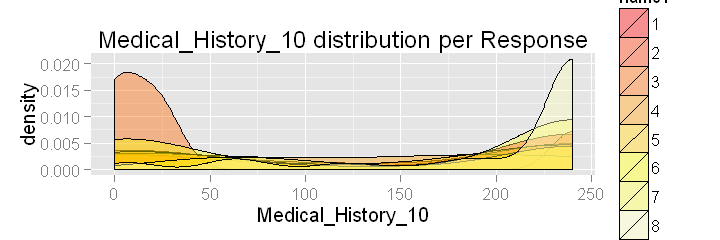

In [26]:
options(repr.plot.width=6, repr.plot.height=2)
g = BMscan(train[train$Medical_History_10 >= 0,], "Medical_History_10")
g = g + xlab("Medical_History_10") + ggtitle("Medical_History_10 distribution per Response")
g
# loop used for exploration - not run in this file
#for (i in names(train)) {
#   BMscan(train = train, target = i)
#   readkey()
#}

## Focus on Medical_History_10
More detailed look at Medical_History_10 reveals distinct profile for Response 3 and 8. Drilling down reveals no strong association with BMI, but a significant one with Age. It appears that Medical_History_10 is associated with older people, but can be seen in younger individuals in Response 5. The addition of a variable( Age * Medical_History_10) further separates Response 3. Unfortunately, Medical_History_10 has 99% missing values, therefore it would be helpful for only a small fraction of cases.

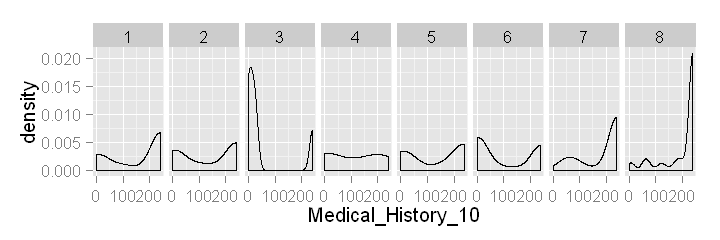

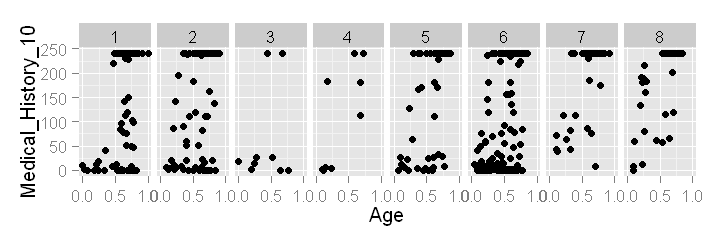

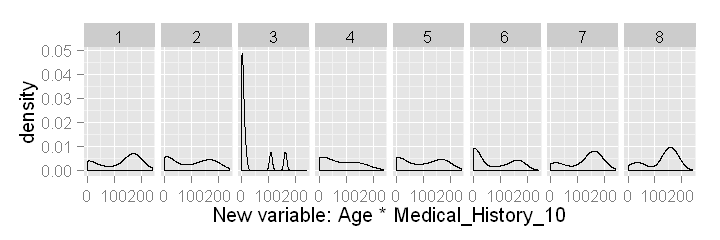

In [31]:
options(repr.plot.width=6, repr.plot.height=2)
MH10 = train %>% select(Response, BMI, Ins_Age, Medical_History_10) %>% filter(Medical_History_10 >= 0)
ggplot(MH10, aes(Medical_History_10))+ geom_density() + facet_wrap(~Response, nrow = 1) + scale_x_continuous(breaks = pretty(MH10$Medical_History_10, n = 2))
ggplot(MH10, aes(x = Ins_Age, y = Medical_History_10)) + geom_point() + facet_wrap(~Response, nrow = 1) + xlab("Age") + scale_x_continuous(breaks = pretty(MH10$Ins_Age, n = 2))
MH10  = MH10 %>% mutate(MH10xIns_Age = Medical_History_10 * Ins_Age)
ggplot(MH10, aes(MH10xIns_Age))+geom_density()  +facet_wrap(~Response, nrow = 1) + xlab("New variable: Age * Medical_History_10") + scale_x_continuous(breaks = pretty(MH10$MH10xIns_Age, n = 2))

## Medical keywords
Medical keywords 1-48 are coded as 0 or 1, with 1 being rare (0-5%). Assuming these indicate specific conditions, they might have a significat impact on Response. while any individual keyword was not strikingly predictive,  the accumulation of several per individual might be informative. Indeed, as seen below, the leaner Response 4 and 8 rarely have more than 2 keywords, while Response 1,2, and 6 have up to 5. 

Warning message:
: Removed 158 rows containing non-finite values (stat_density).Warning message:
: Removed 108 rows containing non-finite values (stat_density).Warning message:
: Removed 7 rows containing non-finite values (stat_density).Warning message:
: Removed 45 rows containing non-finite values (stat_density).Warning message:
: Removed 70 rows containing non-finite values (stat_density).Warning message:
: Removed 41 rows containing non-finite values (stat_density).Warning message:
: Removed 14 rows containing non-finite values (stat_density).

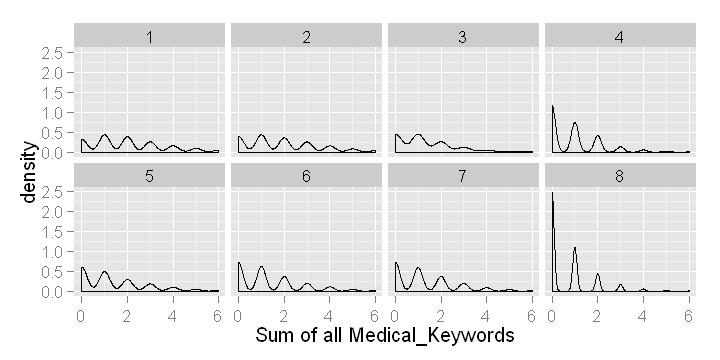

In [35]:
options(repr.plot.width=6, repr.plot.height=3)
m.key = names(train)[grep("Medical_Keyword", x = names(train) )]
m.key.sum = rowSums(train[,m.key], na.rm = TRUE)
train$MkeyS = m.key.sum
df = train %>% select(Response, MkeyS, BMI) %>% filter(MkeyS >=0)
ggplot(df, aes(MkeyS)) + geom_density() + facet_wrap(~Response, nrow = 2) + xlim(c(0,6)) + xlab("Sum of all Medical_Keywords")

## Summary
Visual exploratory data analysis revealed the importance of BMI and Age in classification of life-insurance policies. Some Medical_History and Medical_Keyword terms are more unevenly distributed amoung Response levels, and can be used in development of new features that better capture interaction between variables. This analysis, especially with decoded variable titles, can provide insight into the key parameters determining life insurance policy classification.